# Murcko histogram split

In [19]:
from rdkit import Chem
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from dreams.algorithms.murcko_hist import murcko_hist, are_sub_hists
from dreams.utils.data import MSData, evaluate_split
from dreams.utils.plots import init_plotting
from dreams.definitions import *
tqdm.pandas()
%load_ext autoreload
%autoreload 2

## Introduction

Let's look at the example of a Murcko histogram for the luciferine molecule.

Original molecule:


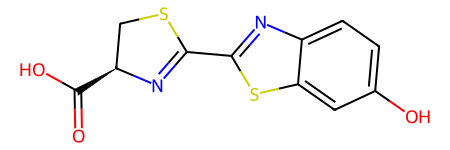

Murcko scaffold:


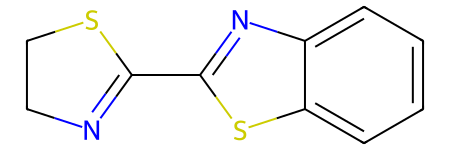

Murcko histogram: {'0_1': 1, '1_0': 1, '1_1': 1}


In [18]:
hist = murcko_hist(Chem.MolFromSmiles('O=C(O)[C@@H]1/N=C(\SC1)c2sc3cc(O)ccc3n2'), show_mol_scaffold=True)
print('Murcko histogram:', hist)

The resulting Murcko histogram is a dictionary where the number of elements corresponds to the number of rings in the molecule's Murcko scaffold. Each key in the dictionary contains two values separated by an underscore: the first value represents the number of neighboring rings, and the second value represents the number of neighboring scaffold linkers. The corresponding values in the dictionary represent the counts of each ring type in the molecule's Murcko scaffold.

Let's now create a training-validation split of the [MassSpecGym](https://huggingface.co/datasets/roman-bushuiev/MassSpecGym) dataset based on the Murcko histograms.

## Load the MassSpecGym dataset

In [3]:
msdata = MSData.from_mgf('../data/MassSpecGym.mgf', prec_mz_col='PRECURSOR_MZ', mol_col='SMILES', adduct_col='ADDUCT', in_mem=False, mode='a')
df = msdata.to_pandas()
df_us = df.drop_duplicates(subset=[SMILES]).copy()  # Uniquify SMILES

## 1. Compute Murcko histograms

In [4]:
# Compute Murcko histograms
df_us['MurckoHist'] = df_us[SMILES].progress_apply(
    lambda x: murcko_hist(Chem.MolFromSmiles(x))
)

# Convert dictionaries to strings for easier handling
df_us['MurckoHistStr'] = df_us['MurckoHist'].astype(str)

100%|██████████| 31602/31602 [01:48<00:00, 291.41it/s] 


In [11]:
print('Num. unique SMILES:', df[SMILES].nunique(), 'Num. unique Murcko histograms:', df_us['MurckoHistStr'].nunique())
print('Top 20 most common Murcko histograms:')
df_us['MurckoHistStr'].value_counts()[:20]

Num. unique SMILES: 31602 Num. unique Murcko histograms: 515
Top 20 most common Murcko histograms:


MurckoHistStr
{'0_1': 1, '1_0': 1, '1_1': 1}              3964
{'0_1': 2}                                  3457
{'0_0': 1}                                  3054
{}                                          3027
{'0_1': 2, '0_2': 1}                        2308
{'1_0': 2}                                  1753
{'0_1': 1, '0_2': 1, '1_0': 1, '1_1': 1}    1202
{'1_0': 2, '2_0': 2}                        1199
{'1_0': 2, '2_0': 1}                        1187
{'0_1': 2, '1_1': 2}                         845
{'0_1': 2, '1_0': 1, '1_2': 1}               672
{'0_1': 2, '0_2': 2}                         641
{'0_1': 1, '1_0': 1, '1_1': 1, '2_0': 1}     626
{'1_0': 2, '1_1': 2}                         563
{'0_1': 3}                                   450
{'0_1': 2, '0_2': 1, '1_1': 2}               332
{'1_0': 2, '2_0': 3}                         325
{'0_1': 1, '1_0': 1, '1_1': 1, '2_0': 2}     294
{'0_1': 1, '1_0': 2, '2_1': 1}               276
{'0_1': 2, '1_0': 1, '1_1': 1}               251
Name: 

In [6]:
# Group by MurckoHistStr and aggregate
df_gb = df_us.groupby('MurckoHistStr').agg(
    count=(SMILES, 'count'),
    smiles_list=(SMILES, list)
).reset_index()

# Convert MurckoHistStr to MurckoHist
df_gb['MurckoHist'] = df_gb['MurckoHistStr'].apply(eval)

# Sort by 'n' in descending order and reset index
df_gb = df_gb.sort_values('count', ascending=False).reset_index(drop=True)

df_gb

,MurckoHistStr,count,smiles_list,MurckoHist
0,"{'0_1': 1, '1_0': 1, '1_1': 1}",3964,"[C1=CC=C(C=C1)C2=C(C(=O)NC3=CC=CC=C32)O, CN1C(...","{'0_1': 1, '1_0': 1, '1_1': 1}"
1,{'0_1': 2},3457,[CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC...,{'0_1': 2}
2,{'0_0': 1},3054,"[C[C@@H]1C[C@H]2[C@H](O2)/C=C\C(=O)CC(=O)O1, C...",{'0_0': 1}
3,{},3027,[CCCC[C@@H](C)[C@H]([C@H](C[C@@H](C)C[C@@H](CC...,{}
4,"{'0_1': 2, '0_2': 1}",2308,[CC(C)C1C(=O)NC(C(=O)NC(C(=O)NC(C(=O)N1)CC2=CC...,"{'0_1': 2, '0_2': 1}"
...,...,...,...,...
510,"{'0_1': 4, '0_2': 1, '0_3': 2, '1_0': 1, '1_1'...",1,[COC1=C(C=C(C=C1)C(C2=C(N(C(=S)N(C2=O)C3=CC=CC...,"{'0_1': 4, '0_2': 1, '0_3': 2, '1_0': 1, '1_1'..."
511,"{'0_1': 1, '1_0': 1, '2_1': 1, '3_0': 3, '4_0'...",1,[COC(=O)C12C3CC4C15C(CCN4)(C6=CC=CC=C6N5)OC2OC...,"{'0_1': 1, '1_0': 1, '2_1': 1, '3_0': 3, '4_0'..."
512,"{'0_1': 4, '0_2': 2, '0_3': 1}",1,[C[C@H](C1=CC=CC=C1)NC(=O)[C@@H](CC(=O)N2CCC(C...,"{'0_1': 4, '0_2': 2, '0_3': 1}"
513,"{'0_1': 4, '1_0': 1, '1_2': 1, '2_1': 1}",1,[CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O...,"{'0_1': 4, '1_0': 1, '1_2': 1, '2_1': 1}"


## 2. Split the dataset into training and validation sets based on Murcko histograms

In [7]:
median_i = len(df_gb) // 2
cum_val_mols = 0
val_mols_frac = 0.15  # Approximately 15% of the molecules go to validation set
val_idx, train_idx = [], []

# Iterate from median to start, assigning molecules to train or val sets
for i in range(median_i, -1, -1):
    current_hist = df_gb.iloc[i]['MurckoHist']
    is_val_subhist = any(
        are_sub_hists(current_hist, df_gb.iloc[j]['MurckoHist'], k=3, d=4)
        for j in val_idx
    )

    if is_val_subhist:
        train_idx.append(i)
    else:
        if cum_val_mols / len(df_us) <= val_mols_frac:
            cum_val_mols += df_gb.iloc[i]['count']
            val_idx.append(i)
        else:
            train_idx.append(i)

# Add remaining indices to train set
train_idx.extend(range(median_i + 1, len(df_gb)))
assert(len(train_idx) + len(val_idx) == len(df_gb))

# Map SMILES to their assigned fold
smiles_to_fold = {}
for i, row in df_gb.iterrows():
    fold = 'val' if i in val_idx else 'train'
    for smiles in row['smiles_list']:
        smiles_to_fold[smiles] = fold
df[FOLD] = df[SMILES].map(smiles_to_fold)

# Display fold distributions
print('Distribution of spectra:')
display(df[FOLD].value_counts(normalize=True))
print('Distribution of SMILES:')
display(df.drop_duplicates(subset=[SMILES])[FOLD].value_counts(normalize=True))

Distribution of spectra:


fold
train    0.804482
val      0.195518
Name: proportion, dtype: float64

Distribution of SMILES:


fold
train    0.805487
val      0.194513
Name: proportion, dtype: float64

## 3. Evaluate data leakage

100%|██████████| 6147/6147 [00:00<00:00, 7652.89it/s]


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


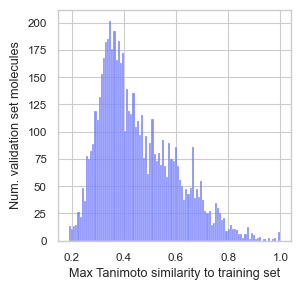

In [8]:
eval_res = evaluate_split(df, n_workers=4)
init_plotting(figsize=(3, 3))
sns.histplot(eval_res['val'], bins=100)
plt.xlabel('Max Tanimoto similarity to training set')
plt.ylabel('Num. validation set molecules')
plt.show()

## 4. Store the dataset with a new `fold` column

In [9]:
msdata.add_column(name=FOLD, data=df[FOLD].tolist())
msdata.to_mgf('../data/MassSpecGym_MurckoHist_split.mgf')

Converting to matchms before saving to mgf: 100%|██████████| 231104/231104 [00:24<00:00, 9611.58it/s] 
